# Добавление модальности в LLM через адаптер

Здесь мы будем работать со таким же паттерном, что в домашней работе, но с другим набором моделей, возьмем:

- frozen encoder (CLIP) + frozen LM (GPT-2)
- и обучаемый mapping network, который превращает эмбеддинг модальности в prefix-токены для языковой модели.

Код основан на кодовой базе, доступной по ссылкам:

- [CLIP-GPT Image Captioning](https://www.kaggle.com/code/seddiktrk/clip-gpt-image-captioning/notebook)
- prefix captioning [notebook](https://colab.research.google.com/drive/1tuoAC5F4sC7qid56Z0ap-stR3rwdk0ZV?usp=sharing), [github](https://github.com/rmokady/CLIP_prefix_caption)

Авторство решения остается за оригинальными авторами и не принадлежит владельцам данного ноутбука.

**Ключевая идея (ClipCap / Prefix captioning):**

* Мы не обучаем CLIP и не обучаем LLM.
* Мы обучаем маленькую сеть `clip_project(clip_emb) -> prefix_embeds` и подмешиваем её в LLM как виртуальные токены в пространстве эмбеддингов.
* Это тот самый fusion: **раннее слияние на уровне эмбеддингов** (early fusion), где модальность приводится к общей токенной форме и дальше всё обрабатывает один LM-трансформер. Это не joint-encoder в смысле "единый трансформер над двумя модальностями", но совместность достигается через общий токенный интерфейс LLM.

## Setup

> Если вы в ДЗ2 используете большие веса с HF Hub, полезно включить Xet/таймауты (особенно в Colab).

In [ ]:
import os

os.environ.pop("HF_XET_HIGH_PERFORMANCE", None)
os.environ["HF_HUB_DISABLE_XET"] = "1"
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "600"
os.environ["HF_HUB_ETAG_TIMEOUT"] = "60"

In [ ]:
!pip -q install "pillow==10.4.0"

In [ ]:
!pip -q install -U transformers datasets evaluate accelerate
!pip -q install -U git+https://github.com/openai/CLIP.git
!pip -q install -U gdown

  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

## CLIP encoder

Сначала получаем эмбеддинг картинки. CLIP даёт нам вектор `prefix_size=512` (для ViT-B/32) - это смысл картинки в CLIP-пространстве.

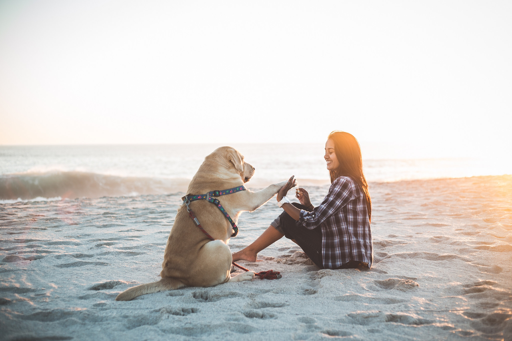

CLIP emb shape: (1, 512)


In [ ]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)

def load_image_from_url(url: str) -> Image.Image:
    import requests
    img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    return img

# демо-картинка BLIPа
img = load_image_from_url("https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg")
display(img.resize((img.size[0]//4, img.size[1]//4)))

@torch.no_grad()
def encode_image_clip(pil_img: Image.Image) -> torch.Tensor:
    x = clip_preprocess(pil_img).unsqueeze(0).to(device)
    emb = clip_model.encode_image(x).float() # [1, 512]
    emb = emb / emb.norm(dim=-1, keepdim=True) # нормировка
    return emb

clip_emb = encode_image_clip(img)
print("CLIP emb shape:", tuple(clip_emb.shape))

## Mapping network

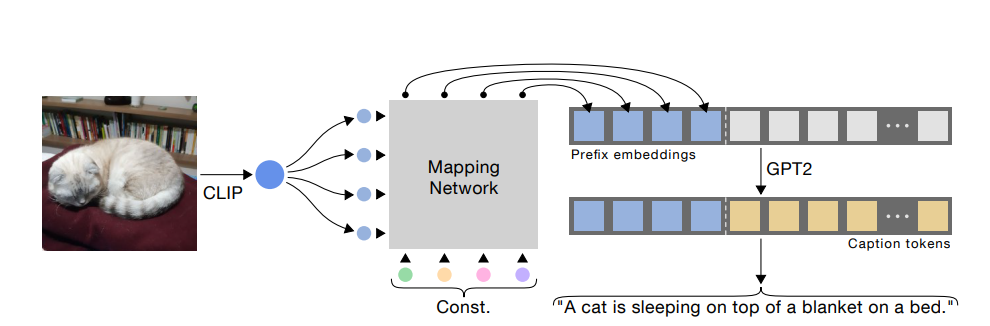

* CLIP (заморожен) кодирует изображение в один вектор.
* Mapping Network (обучаемая) превращает этот вектор в последовательность виртуальных prefix-эмбеддингов длины `prefix_length` в пространстве эмбеддингов GPT-2.
* Эти prefix-эмбеддинги конкатенируются с эмбеддингами текстовых токенов (caption tokens) и подаются в GPT-2.  Обычно LLM замороженный, иногда можно дообучать - но в лёгком варианте учим только mapping.

Это и есть CLIP encoding as a prefix via a mapping network.

> Про Const на схеме: в некоторых реализациях это набор обучаемых пустых/константных токенов, которые вместе с CLIP-вектором помогают построить prefix (например, в transformer-варианте маппера). В нашем текущем коде роль prefix токенов фактически выполняет выход `project(prefix)` (мы их вычисляем из CLIP-эмбеддинга), но при желании можно добавить и отдельные learnable tokens как абляцию.


Теперь делаем prefix-токены для LM. Идея из ClipCap: спроецировать CLIP(512) в prefix_length * hidden_size_LM, потом reshape в `[B, prefix_length, hidden_size]`.

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# замороженный LM
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# у GPT-2 нет pad_token по умолчанию
tokenizer.pad_token = tokenizer.eos_token

gpt = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
gpt.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
class MLP(nn.Module):
    """Проектор: CLIP(512) -> prefix_length * hidden_size_LM"""
    def __init__(self, in_dim: int, out_dim: int, hid_dim: int = 2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

class ClipCapPrefix(nn.Module):
    """
    Frozen LM (GPT-2) + обучаемый projector.
    Учим только projector, который превращает CLIP-эмбеддинг в prefix-эмбеддинги для LM.
    """
    def __init__(self, gpt_model, prefix_length: int, prefix_size: int = 512):
        super().__init__()
        self.gpt = gpt_model
        self.prefix_length = prefix_length

        # берём слой входных эмбеддингов правильным общим способом
        self.wte = self.gpt.get_input_embeddings()
        self.hidden = self.wte.embedding_dim  # hidden_size GPT-2

        self.project = MLP(prefix_size, prefix_length * self.hidden)

        # замораживаем LM: учим только project
        for p in self.gpt.parameters():
            p.requires_grad_(False)

    def forward(self, input_ids: torch.Tensor, prefix: torch.Tensor, attention_mask: torch.Tensor):
        """
        input_ids: [B, T]
        prefix:    [B, 512]  (CLIP embedding)
        attention_mask: [B, T]
        """
        B, T = input_ids.shape

        # эмбеддинги текста: [B, T, H]
        text_emb = self.wte(input_ids)

        # prefix-эмбеддинги: [B, P, H]
        pref = self.project(prefix).view(B, self.prefix_length, self.hidden)

        # fusion: concat(prefix, text) -> [B, P+T, H]
        inputs_embeds = torch.cat([pref, text_emb], dim=1)

        # attention mask тоже расширяем на prefix (там все 1)
        prefix_attn = torch.ones((B, self.prefix_length), device=input_ids.device, dtype=attention_mask.dtype)
        # [B, P+T]
        full_attn = torch.cat([prefix_attn, attention_mask], dim=1)  # [B, P+T]

        # labels: prefix игнорируем (-100), текст оставляем как есть.
        # transformers labels сдвигаются внутри модели, а -100 маскируется из loss.
        labels = torch.cat(
            [torch.full((B, self.prefix_length), -100, device=input_ids.device), input_ids],
            dim=1
        )

        out = self.gpt(inputs_embeds=inputs_embeds, attention_mask=full_attn, labels=labels)
        return out

prefix_length = 10
clipcap = ClipCapPrefix(gpt_model=gpt, prefix_length=prefix_length).to(device)

print("Trainable params (должен быть только projector):",
      sum(p.numel() for p in clipcap.parameters() if p.requires_grad))

Trainable params (должен быть только projector): 16786944


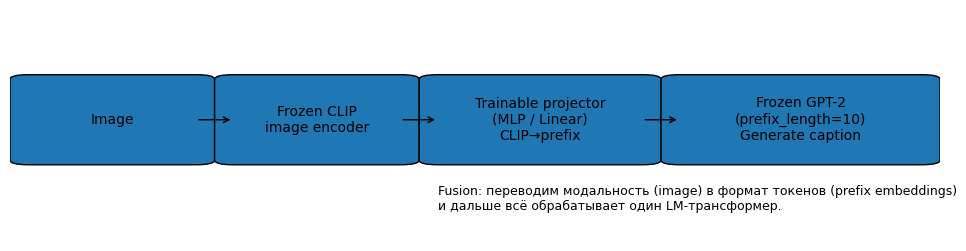

In [ ]:
def visualize_fusion_batch(model, tokenizer, prefix: torch.Tensor, caption: str, max_len=24):
    """
    Показываем:
    - длину prefix и текста
    - attention_mask (1D)
    - labels (где -100 на prefix)
    - нормы prefix-эмбеддингов (интуитивно: 'не нули ли это')
    """
    model.eval()
    device = next(model.parameters()).device

    enc = tokenizer(
        caption,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )
    input_ids = enc["input_ids"].to(device)
    attn_text = enc["attention_mask"].to(device)

    B, T = input_ids.shape

    if hasattr(model, "wte"):
        _wte = model.wte
    elif hasattr(model, "get_input_embeddings"):
        _wte = model.get_input_embeddings()
    elif hasattr(model, "gpt") and hasattr(model.gpt, "get_input_embeddings"):
        _wte = model.gpt.get_input_embeddings()

    H = _wte.embedding_dim
    P = int(model.prefix_length)
    with torch.no_grad():
      pref = model.project(prefix.to(device)).view(B, P, H)  # [B,P,H]

    prefix_attn = torch.ones((B, P), device=device, dtype=attn_text.dtype)
    full_attn = torch.cat([prefix_attn, attn_text], dim=1)    # [B,P+T]

    labels = input_ids.clone()
    labels = torch.cat([torch.full((B, P), -100, device=device, dtype=labels.dtype), labels], dim=1)  # [B,P+T]

    plt.figure(figsize=(12, 1.6))
    plt.imshow(full_attn[0].detach().cpu().numpy()[None, :], aspect="auto")
    plt.yticks([])
    plt.title("attention_mask по позициям (prefix + text) — 1 значит 'участвует'")
    plt.xlabel("позиции токенов")
    plt.show()

    show_labels = labels[0].detach().cpu().numpy()
    plt.figure(figsize=(12, 1.6))
    plt.imshow((show_labels != -100)[None, :], aspect="auto")
    plt.yticks([])
    plt.title("labels участвуют в loss? (белое = да, чёрное = -100)")
    plt.xlabel("позиции токенов")
    plt.show()

    norms = pref[0].norm(dim=-1).detach().cpu().numpy()
    plt.figure(figsize=(10, 2.5))
    plt.bar(np.arange(P), norms)
    plt.title("L2-нормы prefix embeddings по токенам (после projector)")
    plt.xlabel("prefix token id")
    plt.ylabel("||embedding||")
    plt.show()

    print(f"caption tokens T={T}, prefix tokens P={P}, total={P+T}")

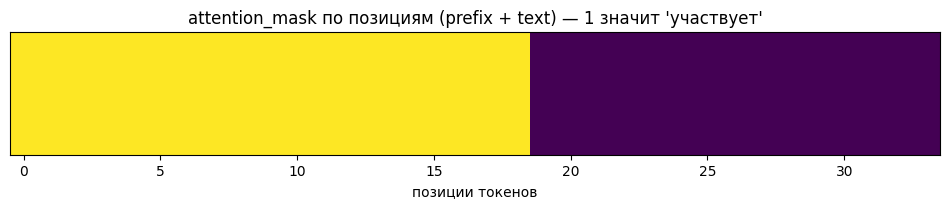

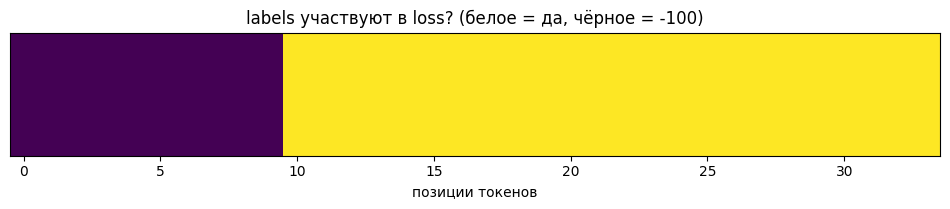

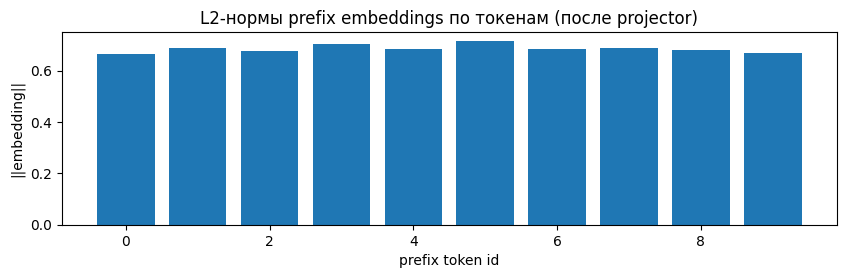

caption tokens T=24, prefix tokens P=10, total=34


In [ ]:
with torch.no_grad():
    pref_embeds = clipcap.project(clip_emb.to(device)).view(clip_emb.shape[0], clipcap.prefix_length, clipcap.hidden)
visualize_fusion_batch(gpt, tokenizer, pref_embeds, "a woman sitting on the beach with a dog", max_len=24)

## Инференс

Генерируем caption (без обучения явно будет слабовато).

Для корректного инференса нужен либо предобученный projector, либо вы сначала делаете fine-tune projector на паре (image, caption). В repo CLIP_prefix_caption есть готовые веса и примеры.

Тем не менее, техника генерации - такая же, как в ориентир-ноутбуках: мы даём LLM inputs_embeds, которые начинаются с prefix-эмбеддингов, и дальше генерируем токены.

In [ ]:
@torch.no_grad()
def generate_caption(model: ClipCapPrefix, prefix: torch.Tensor, max_new_tokens=40, num_beams=5):
    model.eval()
    device = next(model.parameters()).device
    B = prefix.shape[0]

    # убираем warning про loss_type
    if hasattr(model.gpt.config, "loss_type") and model.gpt.config.loss_type is None:
        model.gpt.config.loss_type = "ForCausalLMLoss"

    # пустой старт: начинаем с eos как первого токена
    start_ids = torch.full((B, 1), tokenizer.eos_token_id, device=device, dtype=torch.long)
    attn = torch.ones_like(start_ids)

    # соберём inputs_embeds = [prefix_tokens] + [wte(start)]
    text_emb = model.wte(start_ids)  # [B,1,H]

    # prefix на device + reshape
    pref = model.project(prefix.to(device)).view(B, model.prefix_length, model.hidden)  # [B,P,H]
    inputs_embeds = torch.cat([pref, text_emb], dim=1)  # [B,P+1,H]

    prefix_attn = torch.ones((B, model.prefix_length), device=device, dtype=attn.dtype)
    full_attn = torch.cat([prefix_attn, attn], dim=1)  # [B,P+1]

    # даём generate плейсхолдерные input_ids той же длины (P+1),
    # чтобы у generate была корректная длина промпта в токенах.
    dummy_input_ids = torch.full(
        (B, model.prefix_length + 1),
        tokenizer.eos_token_id,
        device=device,
        dtype=torch.long
    )

    # generate умеет работать с inputs_embeds для GPT2
    out = model.gpt.generate(
        input_ids=dummy_input_ids,
        inputs_embeds=inputs_embeds,
        attention_mask=full_attn,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
        do_sample=False,
        no_repeat_ngram_size=3,
        repetition_penalty=1.2,
        early_stopping=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

    # out включает плейсхолдерный промпт (P+1 токенов), его вырезаем
    gen_ids = out[:, model.prefix_length + 1:]
    text = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
    return text

print(generate_caption(clipcap, clip_emb, max_new_tokens=30, num_beams=3))

The U.S. is the world's most populous country, with a population of 1.3 billion. The United States is the second-largest


## Мини-обучение projector

Итак, мы подходим к части, где реализация остается за вами - но мы раскидали инструкции.

Мы хотим научить только адаптер aka projector превращать признаки модальности в токены (prefix) в пространстве эмбеддингов LLM. Напомним,

* Encoder (модальность) заморожен
* LM (GPT-2) заморожена
* Adapter/Projector обучается

**Что лежит в данных?**

Каждый пример - это пара:

* `modality` = аудио/картинка (или уже precomputed признаки)
* `caption` = текст-описание (цель, которую должна сказать LM)

После токенизации текста у нас есть:

* `input_ids`: `[B, T]`
* `attention_mask`: `[B, T]`

**Окей, а как устроен один training step?**

Шаг 1. Получаем признаки модальности (без градиентов):

* может быть `[B, Dm]` (CLIP-подобное)
* или `[B, Tm, Dm]` (аудио/видео - тогда адаптер ещё и сжимает по времени)

Шаг 2. Адаптер делает префикс-токены для LM:
prefix = Adapter(e) -> форма `[B, P, H]`

* `P` - сколько виртуальных токенов (prefix_length)
* `H` - hidden size LM

Шаг 3. Берём эмбеддинги текста из LM:
text_emb -> `[B, T, H]`

Шаг 4. Раннее слияние:
конкатенируем -> `[B, P+T, H]`

Шаг 5. Делаем `labels`, где префикс не участвует в лоссе -> `[B, P+T]`

-100 - игнорировать позицию при подсчёте .

Шаг 6. Считаем loss и делаем шаг оптимизации только адаптером.




In [ ]:
IGNORE_INDEX = -100

def build_fused_inputs(lm, input_ids, attention_mask, prefix_embeds):
    """
    Дано:
      input_ids:       [B, T]
      attention_mask:  [B, T]
      prefix_embeds:   [B, P, H]
    Вернуть:
      inputs_embeds:   [B, P+T, H]
      full_attn_mask:  [B, P+T]
      labels:          [B, P+T]
    """
    # TODO:
    # получить текстовые эмбеддинги через слой входных эмбеддингов LM
    # собрать inputs_embeds как "prefix + text" по временной оси
    # собрать full_attn_mask как "единицы на prefix + attention_mask"
    # собрать labels как "IGNORE_INDEX на prefix + input_ids"

    pass


def training_step(batch, encoder, adapter, lm, optimizer):
    """
    batch содержит:
      batch["modality"]
      batch["input_ids"]
      batch["attention_mask"]
    Обучаем: только adapter
    """
    # TODO:
    # E = encoder(modality) без градиентов
    # Prefix = adapter(E)
    # inputs_embeds, full_mask, labels = build_fused_inputs(...)
    # out = lm(inputs_embeds=..., attention_mask=..., labels=...)
    # optimizer step
    pass

Ну вот и всё - обучение собрано! Можно еще прогнать пару sanity check'ов - но это уже на ваше усмотрение.

### Доп задание

Можно прямо в этой реализации сделать **3 контролируемых сравнения** и объяснить эффект:

1. Размер адаптера: поменять `prefix_length` (например 5 / 10 / 20) и сравнить `val loss` + qualitative captions.
2. Архитектура projector: Linear vs MLP (1 скрытый слой) и как это влияет на устойчивость и качество.
3. Декодирование: `num_beams=1` vs `num_beams=5`, и отдельно `do_sample=True` (temperature/top_p). Что меняется в данном случае и почему (точность vs разнообразие).
